Cell 1: Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

Cell 2: Download Historical Data

/tmp/ipython-input-1020824792.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


Data downloaded successfully.


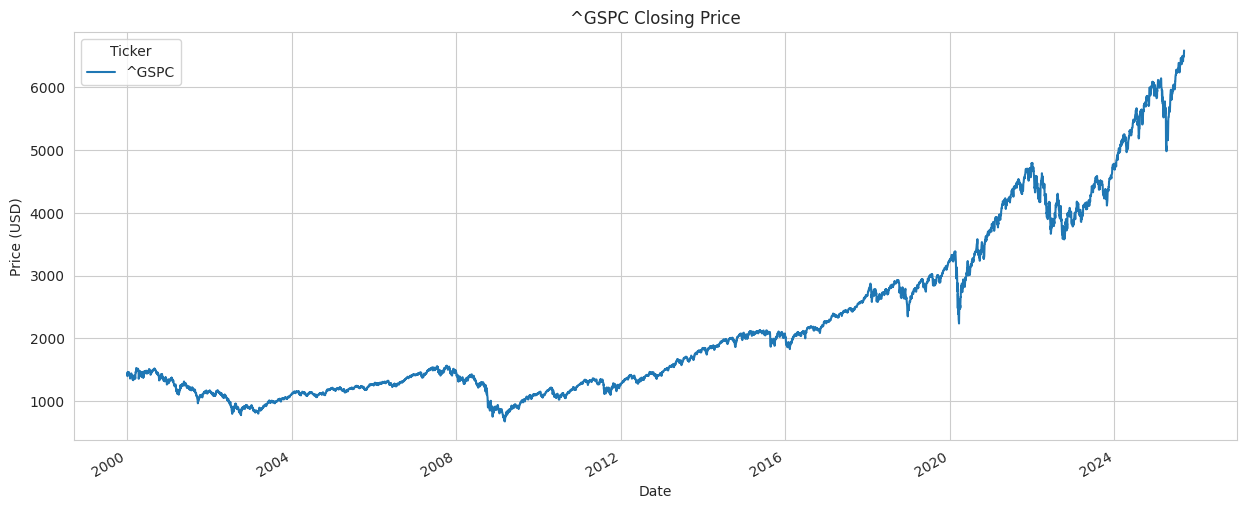

In [2]:
TICKER = '^GSPC'  # S&P 500 Index
START_DATE = '2000-01-01'
END_DATE = '2025-09-12' # Using a recent date

print(f"Downloading data for {TICKER} from {START_DATE} to {END_DATE}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)

if df.empty:
    print("No data downloaded. Please check ticker or date range.")
else:
    print("Data downloaded successfully.")
    df['Close'].plot(figsize=(15, 6), title=f'{TICKER} Closing Price')
    plt.ylabel('Price (USD)')
    plt.show()

Cell 3: Feature Engineering

Here, we create features from the raw price data. A good feature set is critical for the HMM to be able to distinguish between different market regimes.



In [3]:
# Feature 1: Log Returns (the primary feature)
# We use log returns as they are more stationary than prices.
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Feature 2: Volatility (as rolling standard deviation of returns)
# We'll use a 21-day window, which is approximately one trading month.
df['Volatility'] = df['Returns'].rolling(window=21).std() * np.sqrt(252) # Annualized

# Feature 3: Momentum (as the 21-day moving average of returns)
df['Momentum'] = df['Returns'].rolling(window=21).mean() * 252 # Annualized

# Feature 4: Intraday Range
df['Intraday_Range'] = (df['High'] - df['Low']) / df['Close']

# Drop any NaN values that were created by the rolling windows
features_df = df[['Returns', 'Volatility', 'Momentum', 'Intraday_Range']].dropna()

print("Feature engineering complete. Here's a look at the data:")
print(features_df.head())

Feature engineering complete. Here's a look at the data:
Price        Returns Volatility  Momentum Intraday_Range
Ticker                                                  
Date                                                    
2000-02-02 -0.000114   0.257009 -0.386300       0.012149
2000-02-03  0.011185   0.220892  0.217114       0.019130
2000-02-04 -0.000421   0.220900  0.189016       0.010728
2000-02-07 -0.000091   0.220917  0.176459       0.009703
2000-02-08  0.012198   0.204466  0.002081       0.012201


Cell 4: Visualize the Engineered Features

Visualizing the features helps us understand their behavior over time and see if there are any obvious periods of distinct activity that our HMM might pick up on.

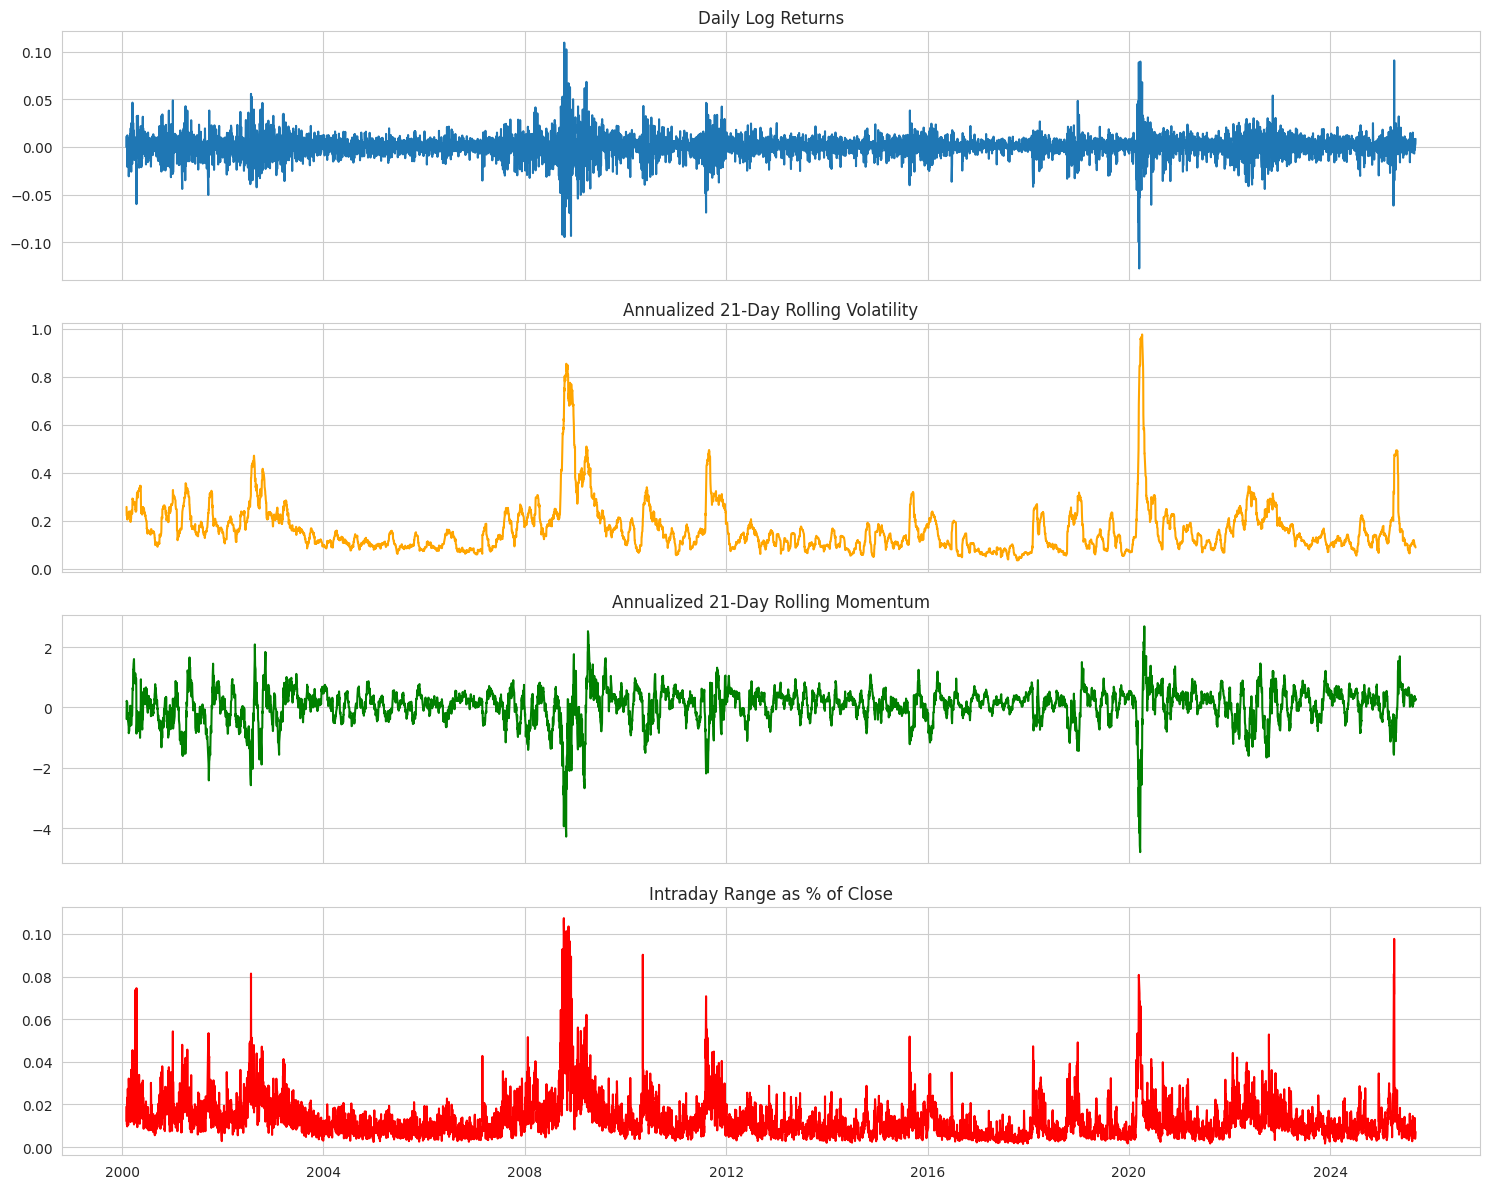

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), sharex=True)

axes[0].plot(features_df.index, features_df['Returns'], label='Log Returns')
axes[0].set_title('Daily Log Returns')

axes[1].plot(features_df.index, features_df['Volatility'], label='21-Day Volatility', color='orange')
axes[1].set_title('Annualized 21-Day Rolling Volatility')

axes[2].plot(features_df.index, features_df['Momentum'], label='21-Day Momentum', color='green')
axes[2].set_title('Annualized 21-Day Rolling Momentum')

axes[3].plot(features_df.index, features_df['Intraday_Range'], label='Intraday Range', color='red')
axes[3].set_title('Intraday Range as % of Close')

plt.tight_layout()
plt.show()

Cell 5: Save the Features for the Next Notebook

We will save our engineered features to a CSV file so we can easily load them in the next notebook where we'll build our Hidden Markov Model.

In [5]:
OUTPUT_FILENAME = 'engineered_features.csv'
features_df.to_csv(OUTPUT_FILENAME)

print(f"Engineered features saved to {OUTPUT_FILENAME}")

Engineered features saved to engineered_features.csv
